In [10]:
from vertexai.preview.language_models import TextEmbeddingModel
model = TextEmbeddingModel.from_pretrained("textembedding-gecko")

embeddings = model.get_embeddings(
    ["Dinner in New York City",
    "Dinner in Paris"]
)
# for embedding in embeddings:
#     vector = embedding.values
#     print(vector)

len(embeddings)

len(embeddings[0].values)

768

In [ ]:
# Load messages
import pandas as pd
import numpy as np
from datetime import timedelta

# Load messages
msg = pd.read_csv('../../output/cleaned_messages_feb2024.csv', 
                  usecols=['pat_mrn_id', 'message_id', 'create_time', 'myc_mesg_subject', 'to_pat_yn', 'combined_text'])

# Filter to non-null messages, sent to patients
msg = msg[~pd.isna(msg.combined_text)]
msg = msg.fillna({'myc_mesg_subject':''})
msg = msg[msg.to_pat_yn=='Y']

# Combine messages from the same day
msg['ds'] = pd.to_datetime(msg.create_time).dt.date
msg = msg.groupby(['pat_mrn_id', 'ds'])[['myc_mesg_subject','combined_text']].agg(lambda x: '\n'.join(x)).reset_index()

# TESTING WITH 100 MESSAGES
# msg = msg[:100]
# print(msg.shape)

msg

# Extract embeddings

In [66]:
embeddings = model.get_embeddings(msg.combined_text.tolist()[:10])

len(embeddings)

10

In [67]:
# https://stackoverflow.com/questions/31822190/how-does-the-timeouttimelimit-decorator-work
from functools import wraps
import errno
import os
import signal

class TimeoutError(Exception):
    def __init__(self, value = "Timed Out"):
        self.value = value
    def __str__(self):
        return repr(self.value)

def timeout(seconds=100, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wraps(func)(wrapper)

    return decorator


@timeout(60)
def gen_embeddings_with_timeout(m):
    try:
        return(model.get_embeddings(m))
    except Exception as e:
        print(e)
        return("Error")

# Test
t = gen_embeddings_with_timeout(msg.combined_text.tolist()[:10])
print("SUCCESS")

SUCCESS


In [72]:
batch_size = 50
total_batches = -(msg.shape[0] // -batch_size)
print(f"total_batches={total_batches}")

input_messages = msg.combined_text.tolist()
# output_embeddings = []

start_index = 2900
for i in range(start_index, len(msg), batch_size):
    print(f"{i}/{len(msg)-1}")
    # start_t = time.time()
    try:
        outputs = gen_embeddings_with_timeout(input_messages[i : i + batch_size])
        output_embeddings += [x.values for x in outputs]
    except:
        outputs1 = gen_embeddings_with_timeout(input_messages[i : i + batch_size//2])
        outputs2 = gen_embeddings_with_timeout(input_messages[i + batch_size//2 : i + batch_size])
        outputs = outputs1 + outputs2
        output_embeddings += [x.values for x in outputs]
    # elapsed_t = time.time() - start_t
    # print(f"elapsed = {elapsed_t}")
    # # Add wait to ensure at least 60 seconds between batches of 300 requests to API
    # time.sleep(max(1, 1 + batch_size/300*60 - elapsed_t))

total_batches=282
2900/14065
400 Request is too large: 20000 total tokens allowed in a request, 29426 received
2950/14065
3000/14065
3050/14065
3100/14065
3150/14065
3200/14065
3250/14065
3300/14065
3350/14065
3400/14065
3450/14065
3500/14065
3550/14065
3600/14065
3650/14065
3700/14065
3750/14065
3800/14065
3850/14065
3900/14065
3950/14065
4000/14065
4050/14065
4100/14065
4150/14065
4200/14065
4250/14065
4300/14065
4350/14065
4400/14065
4450/14065
4500/14065
4550/14065
4600/14065
4650/14065
4700/14065
4750/14065
4800/14065
4850/14065
4900/14065
4950/14065
5000/14065
5050/14065
5100/14065
5150/14065
5200/14065
5250/14065
5300/14065
5350/14065
5400/14065
5450/14065
5500/14065
5550/14065
5600/14065
5650/14065
5700/14065
5750/14065
5800/14065
5850/14065
5900/14065
5950/14065
6000/14065
6050/14065
6100/14065
6150/14065
6200/14065
6250/14065
6300/14065
6350/14065
6400/14065
6450/14065
6500/14065
6550/14065
6600/14065
6650/14065
6700/14065
6750/14065
6800/14065
6850/14065
6900/14065
6950/1406

In [ ]:
# Put embeddings into dataframe
embeddings_df = pd.DataFrame(np.array(output_embeddings))
embeddings_df.columns = [f'e{x}' for x in embeddings_df.columns]

msg_w_embeddings = pd.concat([msg, embeddings_df], axis=1)
msg_w_embeddings

In [ ]:
# # https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/
# def reduce_mem_usage(df):
#     start_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

#     for col in df.columns:
#         col_type = df[col].dtype
#     if col_type != object:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
#                     df[col] = df[col].astype(np.uint8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
#                     df[col] = df[col].astype(np.uint16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
#                     df[col] = df[col].astype(np.uint32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)
#                 elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
#                     df[col] = df[col].astype(np.uint64)
#             elif str(col_type)[:5] == 'float':
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)

#     end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
#     return df

# msg_w_embeddings = reduce_mem_usage(msg_w_embeddings)

In [79]:
# Save messages and labels
msg_w_embeddings.to_parquet('../../output/text_embeddings.parquet', index=False)

# Sanity check looking at embeddings by subject

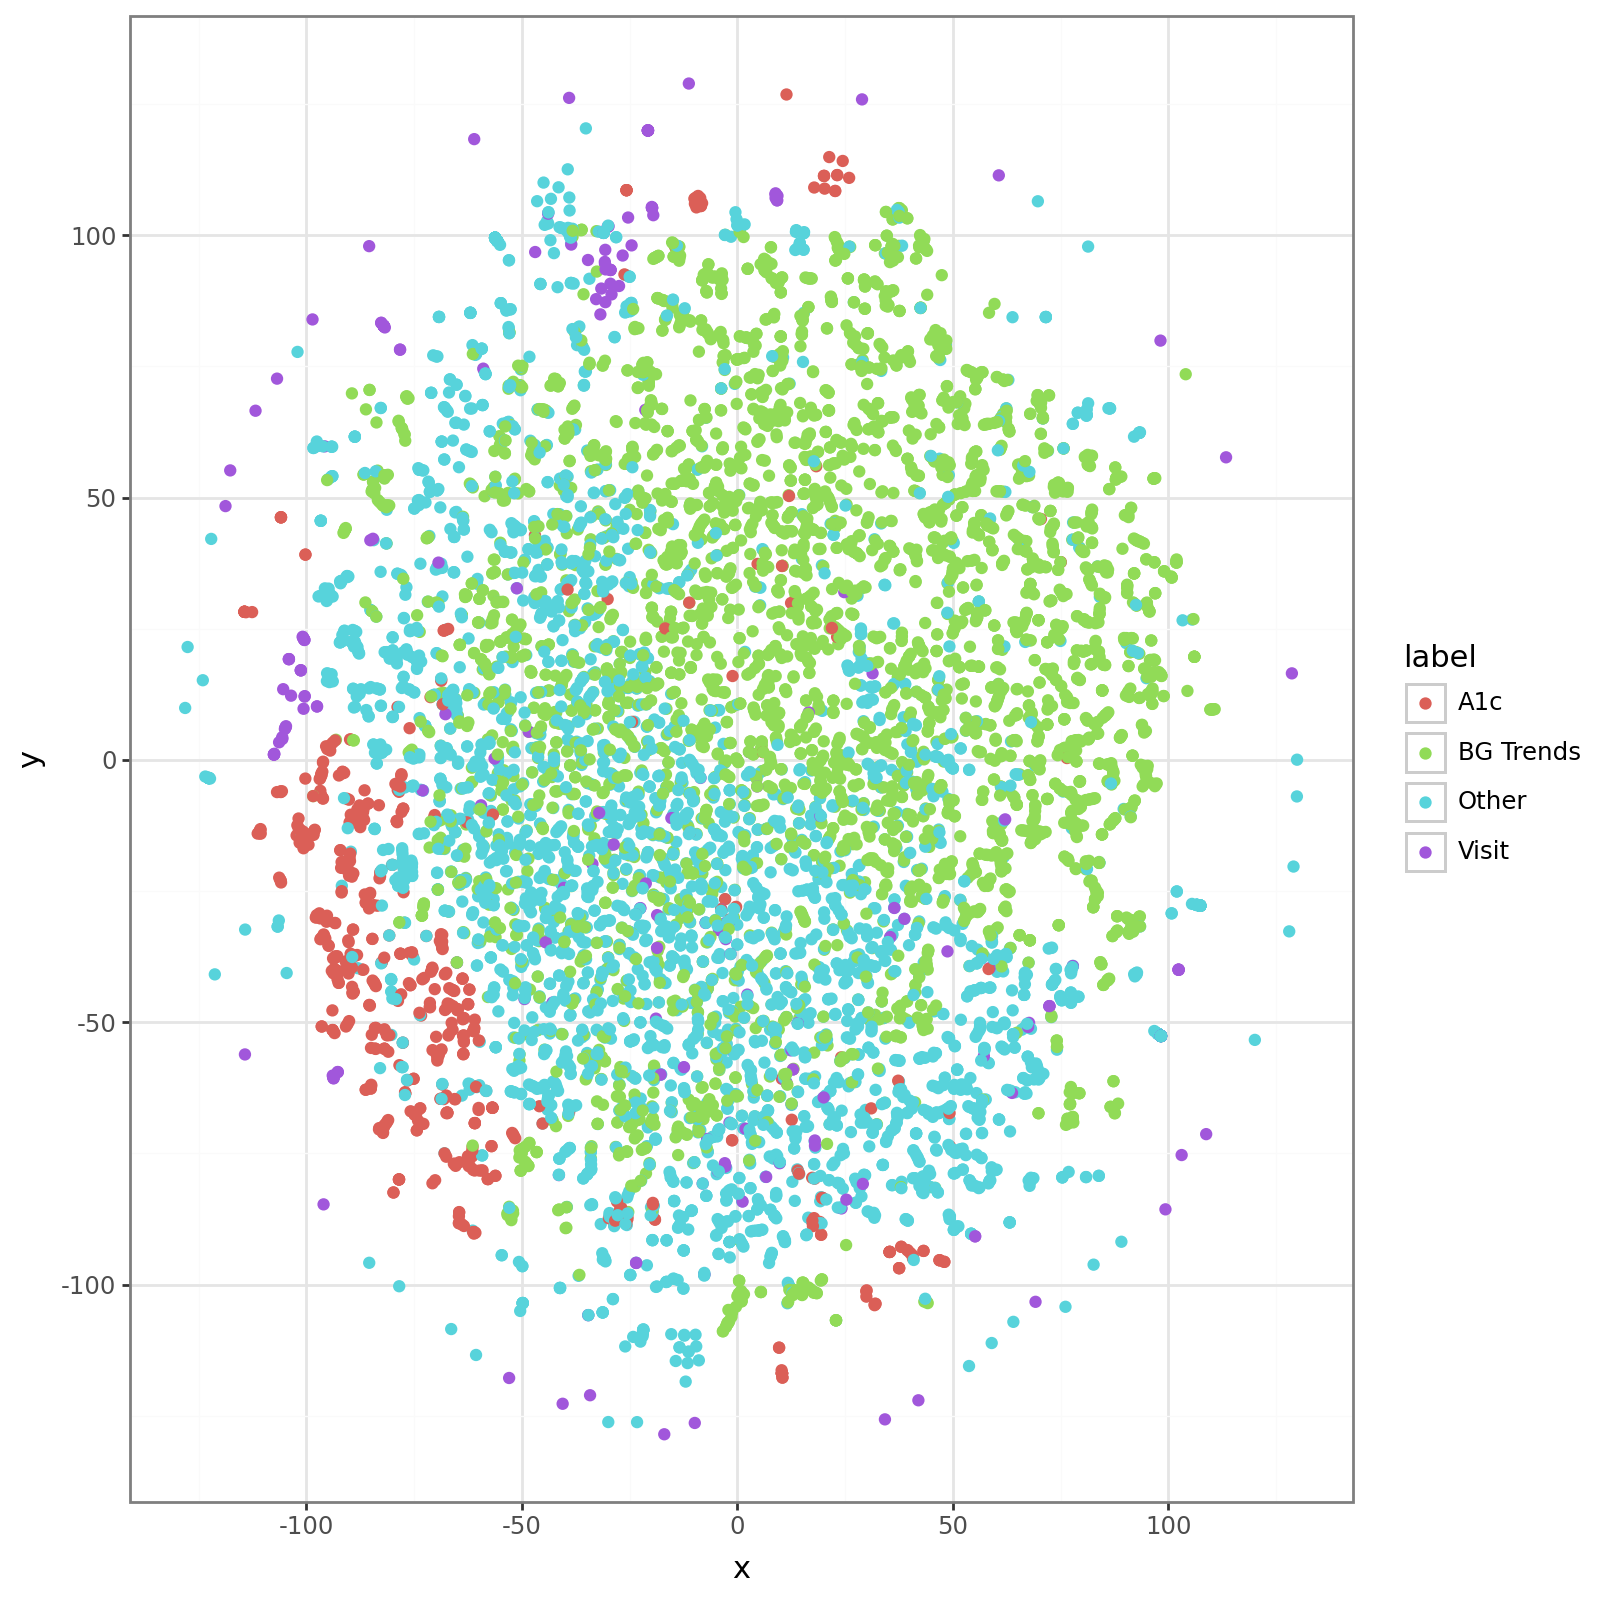

In [97]:
from sklearn.manifold import TSNE
import plotnine
from plotnine import ggplot, aes, geom_point, theme_bw, facet_wrap

N_POINTS = 10000

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(msg_w_embeddings[[x for x in msg_w_embeddings.columns if x[0]=='e']].to_numpy())

# BG trends subject or other
bg_trends_or_other = np.where(msg_w_embeddings.myc_mesg_subject.str.contains('BG trends', case=False), 'BG Trends', 'Other')
bg_trends_or_other = np.where(msg_w_embeddings.myc_mesg_subject.str.contains('visit', case=False), 'Visit', bg_trends_or_other)
bg_trends_or_other = np.where(msg_w_embeddings.myc_mesg_subject.str.contains('A1c', case=False), 'A1c', bg_trends_or_other)
                                                                                                   
plotnine.options.figure_size = (8, 8)

df = pd.DataFrame({
    "x": X_embedded[:N_POINTS,0],
    "y": X_embedded[:N_POINTS,1],
    "label": bg_trends_or_other[:N_POINTS]
})

(
    ggplot(df)  # What data to use
    + aes(x="x", y="y", color="label")
    + geom_point() + theme_bw()
)